In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.feature_selection import RFECV

In [4]:
import lightgbm as lgb

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import weight_of_evidence

In [7]:
import importlib

importlib.reload(weight_of_evidence)

<module 'weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence.py'>

In [8]:
data = pd.read_csv("~/Downloads/application_train.csv")

In [9]:
EXCLUDE_COLS = ["SK_ID_CURR", "TARGET", "CODE_GENDER", "ORGANIZATION_TYPE"]

In [10]:
CATERORICAL_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("O").columns

In [11]:
NUMERIC_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("int64").columns

In [12]:
data[CATERORICAL_COLS] = data[CATERORICAL_COLS].fillna("MISSING")

In [13]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [14]:
ohe_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATERORICAL_COLS),
    ]
)

In [15]:
log_reg_cv = LogisticRegressionCV(penalty="l2", solver="lbfgs", max_iter=1e6, cv=3)

In [16]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=1e6)

In [17]:
ohe_logit = Pipeline(
    steps=[("preprocessor", ohe_preprocessor), ("log_reg_classifier", log_reg),]
)

In [18]:
ohe_lgb = Pipeline(
    steps=[("preprocessor", ohe_preprocessor), ("lgb_classifier", lgb.LGBMClassifier())]
)

In [19]:
combined_results = pd.DataFrame()

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [21]:
X = data.drop(columns=EXCLUDE_COLS)
y = data.TARGET

In [22]:
def get_cv_results(X, y, cv, clf, model_name):
    results = {"auc": [], "fold": []}
    fold = 1
    for train, test in cv.split(X, y):
        print(f"fold {fold}")
        prediction = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        auc = roc_auc_score(y_true=y.iloc[test], y_score=prediction[:, 1])
        results["auc"].append(auc)
        results["fold"].append(fold)
        print(f"auc {auc}")
        fold += 1
    results_df = pd.DataFrame(results)
    results_df["model"] = model_name
    return results_df

In [23]:
combined_results = get_cv_results(X, y, cv, ohe_logit, "ohe logit")

fold 1
auc 0.6611380729879756
fold 2
auc 0.665069014060448
fold 3
auc 0.6556058566642657
fold 4
auc 0.660426676353663
fold 5
auc 0.6671906486712682


In [24]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
ohe logit,0.661886


In [25]:
combined_results = combined_results.append(
    get_cv_results(X, y, cv, ohe_lgb, "ohe lgbm")
)

fold 1
auc 0.6654692828931603
fold 2
auc 0.6663359632538226
fold 3
auc 0.6549244093125763
fold 4
auc 0.6624041068133852
fold 5
auc 0.6680383142937649


In [26]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
ohe lgbm,0.663434
ohe logit,0.661886


In [27]:
woebin_logit = Pipeline(
    steps=[
        ("tree_bin", weight_of_evidence.TreeBinner()),
        ("woe_scale", weight_of_evidence.WoeScaler()),
        ("standard_scale", StandardScaler()),
        ("log_reg_classifier", log_reg),
    ]
)

In [28]:
combined_results = combined_results.append(
    get_cv_results(X, y, cv, woebin_logit, "woe regression")
)

fold 1
auc 0.7316305261383079
fold 2
auc 0.7337680298160848
fold 3
auc 0.7391530016231739
fold 4
auc 0.7395422894196443
fold 5
auc 0.7364918598789079


In [29]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
ohe lgbm,0.663434
ohe logit,0.661886
woe regression,0.736117


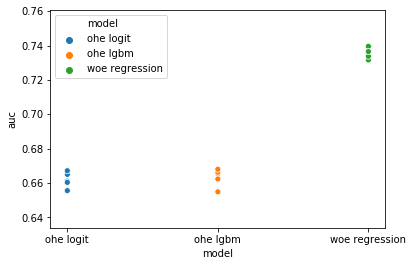

In [30]:
sns.scatterplot(data=combined_results, x="model", y="auc", hue="model")

In [31]:
"""rfe = RFECV(estimator=woebin_logit, 
            step=1, min_features_to_select=1, cv=cv)"""

'rfe = RFECV(estimator=woebin_logit, \n            step=1, min_features_to_select=1, cv=cv)'

In [32]:
woebin_logit.fit(X, y)

Pipeline(memory=None,
         steps=[('tree_bin',
                 TreeBinner(max_depth=None, min_gini_decrease=None,
                            min_samples_per_node=None)),
                ('woe_scale', WoeScaler(clip_thresh=100000.0)),
                ('standard_scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_reg_classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000000.0,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [35]:
def plot_reg_coefs(var_names, coefficients, n=10, output_dir=None, verbose=True):
    """
    Find logit regression feature importance
    Args:
        var_names (series): variable names
        coefficients (series): regression coefficients
        n (integer): how many features to plot
    """
    coef_df = pd.DataFrame()
    coef_df["var_names"] = var_names
    coef_df["coef_vals"] = coefficients
    coef_df["abs_vals"] = np.abs(coef_df.coef_vals)
    coef_df = coef_df.set_index("var_names").sort_values(by="abs_vals", ascending=True)
    if verbose:
        plt.figure(figsize=(4, 8))
        ax = coef_df.tail(n).coef_vals.plot.barh()
        plt.title(f"Top {n} features - logistic regression \n")
        plt.show()
    return coef_df.reset_index()

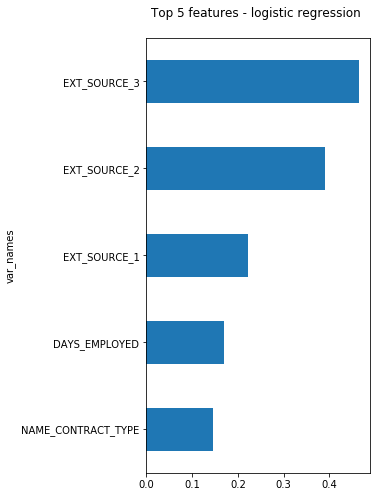

In [36]:
var_importance = plot_reg_coefs(
    X.columns, woebin_logit["log_reg_classifier"].coef_[0], n=5
)

In [37]:
top_5 = var_importance.tail(5).var_names

In [38]:
weight_of_evidence.plot_bins(X,y,top_5[::-1],woebin_logit['tree_bin'].splits_)

AssertionError: 